# Predicting Drive Failure

# Importing Datasets

Downloading Dataset from BackBlaze

In [42]:
# Downloading datasets
# Using 2016 dataset
urls = ["https://f001.backblazeb2.com/file/Backblaze-Hard-Drive-Data/data_Q1_2016.zip",\
        "https://f001.backblazeb2.com/file/Backblaze-Hard-Drive-Data/data_Q2_2016.zip",\
        "https://f001.backblazeb2.com/file/Backblaze-Hard-Drive-Data/data_Q3_2016.zip",\
        "https://f001.backblazeb2.com/file/Backblaze-Hard-Drive-Data/data_Q4_2016.zip"]
for url in urls:
  !wget {url}

--2024-04-27 07:18:31--  https://f001.backblazeb2.com/file/Backblaze-Hard-Drive-Data/data_Q1_2016.zip
Resolving f001.backblazeb2.com (f001.backblazeb2.com)... 104.153.233.181
Connecting to f001.backblazeb2.com (f001.backblazeb2.com)|104.153.233.181|:443... connected.
HTTP request sent, awaiting response... 200 
Length: 270281914 (258M) [application/zip]
Saving to: ‘data_Q1_2016.zip.1’

data_Q1_2016.zip.1  100%[===================>] 257.76M  47.1MB/s    in 5.4s    

2024-04-27 07:18:38 (47.3 MB/s) - ‘data_Q1_2016.zip.1’ saved [270281914/270281914]

--2024-04-27 07:18:38--  https://f001.backblazeb2.com/file/Backblaze-Hard-Drive-Data/data_Q2_2016.zip
Resolving f001.backblazeb2.com (f001.backblazeb2.com)... 104.153.233.181
Connecting to f001.backblazeb2.com (f001.backblazeb2.com)|104.153.233.181|:443... connected.
HTTP request sent, awaiting response... 200 
Length: 292369418 (279M) [application/zip]
Saving to: ‘data_Q2_2016.zip.1’

data_Q2_2016.zip.1  100%[===================>] 278.83M  3

In [43]:
# Unzipping contents
# capture, hides the output of the cell, so we don't have to see all the unzipped items
%%capture
# Creating data directory
!mkdir data
paths = ["/content/data_Q1_2016.zip", "/content/data_Q2_2016.zip", "/content/data_Q3_2016.zip", "/content/data_Q4_2016.zip"]
for i in range(len(paths)):
  !unzip -o {paths[i]} -d "/content/data"

# Preprocessing the data

Next, we import necessary libraries and load the data into a DataFrame

In [44]:
# We will be using pycaret, so we don't have to import all the different models
%%capture
!pip install pycaret
!pip install mlflow

In [45]:
# Importing necessary libraries
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

# Defining a random state
RANDOM = 3856

In [52]:
# Getting all file names or dates
data_path = '/content/data'

data_files = os.listdir(data_path)
data_files.remove("__MACOSX")
data_files.sort(reverse = True)

In [47]:
# Columns used based upon different articles
# https://www.backblaze.com/blog/using-machine-learning-to-predict-hard-drive-failures/
cols = ["date", "serial_number", "model","capacity_bytes","failure","smart_5_normalized","smart_187_normalized","smart_188_normalized",\
 "smart_197_normalized","smart_198_normalized",\
 "smart_5_raw","smart_187_raw","smart_188_raw","smart_198_raw",\
 "smart_197_raw"]

In [53]:
# Loading Dataset
# We only want data for hard drives that have failed
data = pd.read_csv(data_path + "/" + data_files[0], usecols = cols)
data_failed_hdds = data.loc[data.failure==1]["serial_number"]
data = data.loc[data["serial_number"].isin(data_failed_hdds)]
for files in range(1, len(data_files)):
  temp = pd.read_csv(data_path + "/" + data_files[files], usecols = cols)
  data = pd.concat([data, temp], ignore_index=True)
  data_failed_hdds = data.loc[data.failure==1]["serial_number"]
  data = data.loc[data["serial_number"].isin(data_failed_hdds)]

# Check
print(data.shape)
data.head()

(232693, 15)


,date,serial_number,model,capacity_bytes,failure,smart_5_normalized,smart_5_raw,smart_187_normalized,smart_187_raw,smart_188_normalized,smart_188_raw,smart_197_normalized,smart_197_raw,smart_198_normalized,smart_198_raw
0,2016-12-31,ZA10Q2F7,ST8000DM002,8001563222016,1,100.0,472.0,83.0,17.0,98.0,0.0,81.0,9736.0,81.0,9736.0
1,2016-12-31,Z30111PC,ST4000DM000,4000787030016,1,100.0,0.0,100.0,0.0,100.0,1.0,100.0,0.0,100.0,0.0
2,2016-12-31,S301LJ5G,ST4000DM000,4000787030016,1,100.0,0.0,94.0,6.0,100.0,0.0,100.0,136.0,100.0,136.0
3,2016-12-31,Z305D4X6,ST4000DM000,4000787030016,1,100.0,0.0,67.0,33.0,100.0,0.0,99.0,320.0,99.0,320.0
4,2016-12-30,ZA10Q2F7,ST8000DM002,8001563222016,0,100.0,0.0,100.0,0.0,100.0,0.0,100.0,0.0,100.0,0.0


In [54]:
# Finding number of HDDs that have failed
data_failed_hdds = data.loc[data.failure==1]["serial_number"]
len(data_failed_hdds)

1428

In [55]:
# Checking shape of both datasets
print(data.shape)

(232693, 15)


#Feature Engineering

In [56]:
# We add a new feature, number of days left till failure
# So that we can incorporate dates directly into our data
data["end_date"] = data.groupby("serial_number")["date"].transform("max")
data["end_date"] = pd.to_datetime(data["end_date"])
data["date"] = pd.to_datetime(data["date"])
data["date_diff"] = data["end_date"] - data["date"]
data["date_diff"].describe()

count                         232693
mean     115 days 21:54:58.902846240
std       84 days 18:53:34.992426534
min                  0 days 00:00:00
25%                 45 days 00:00:00
50%                 99 days 00:00:00
75%                174 days 00:00:00
max                365 days 00:00:00
Name: date_diff, dtype: object

In [57]:
# Handling null values
data.isnull().sum()

date                        0
serial_number               0
model                       0
capacity_bytes              0
failure                     0
smart_5_normalized          3
smart_5_raw                 3
smart_187_normalized    45274
smart_187_raw           45274
smart_188_normalized    45274
smart_188_raw           45274
smart_197_normalized        3
smart_197_raw               3
smart_198_normalized        3
smart_198_raw               3
end_date                    0
date_diff                   0
dtype: int64

In [58]:
# Dropping colums which have NaN values for more than 95% of the dataset
data = data[data.columns[~(data.isna().sum().values/len(data) > 0.05)]]
# For remaining NaN values we drop the rows
data.dropna(inplace = True)
# Redefining the index
data.reset_index(inplace=True, drop=True)
# Checking if NaN values are gone
data.isnull().sum()

date                    0
serial_number           0
model                   0
capacity_bytes          0
failure                 0
smart_5_normalized      0
smart_5_raw             0
smart_197_normalized    0
smart_197_raw           0
smart_198_normalized    0
smart_198_raw           0
end_date                0
date_diff               0
dtype: int64

In [59]:
# Dropping unwanted columns for training
data = data.drop(['date', 'serial_number', 'model','end_date'], axis=1)
data.head()

,capacity_bytes,failure,smart_5_normalized,smart_5_raw,smart_197_normalized,smart_197_raw,smart_198_normalized,smart_198_raw,date_diff
0,8001563222016,1,100.0,472.0,81.0,9736.0,81.0,9736.0,0 days
1,4000787030016,1,100.0,0.0,100.0,0.0,100.0,0.0,0 days
2,4000787030016,1,100.0,0.0,100.0,136.0,100.0,136.0,0 days
3,4000787030016,1,100.0,0.0,99.0,320.0,99.0,320.0,0 days
4,8001563222016,0,100.0,0.0,100.0,0.0,100.0,0.0,1 days


In [60]:
# Changing datetime object to integers
data["date_diff"] = data["date_diff"].dt.days

# Failure Classification

<Axes: xlabel='failure', ylabel='count'>

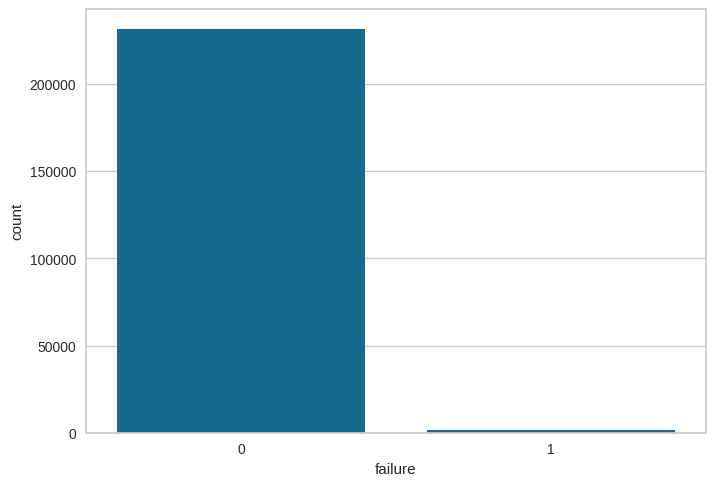

In [61]:
# We begin by trying to classify Failed and Non-Failed drives
# Let's first check the distribution
sns.countplot(data = data, x = "failure")

<Axes: >

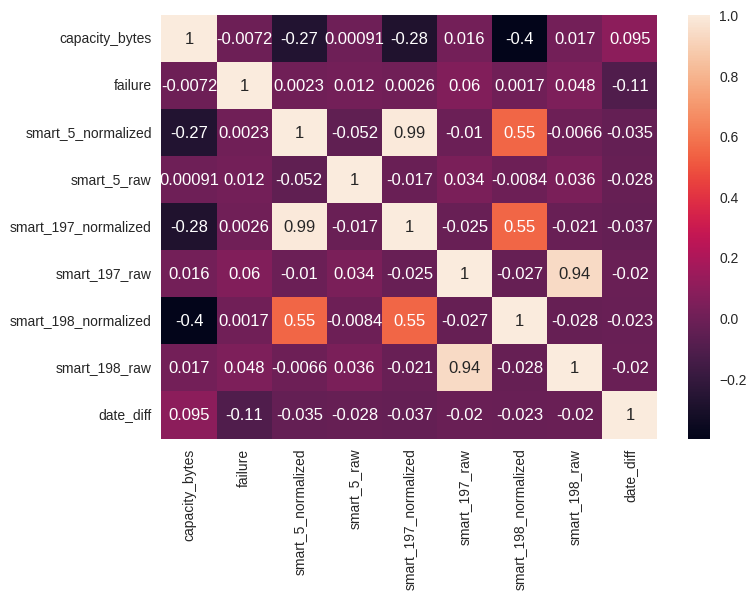

In [62]:
# There is a huge imbalance of data
# Let's also see the correlation matrix between all the different numerical variables
corr = data.corr()
sns.heatmap(corr, annot = True)

<Axes: xlabel='smart_5_normalized', ylabel='smart_198_normalized'>

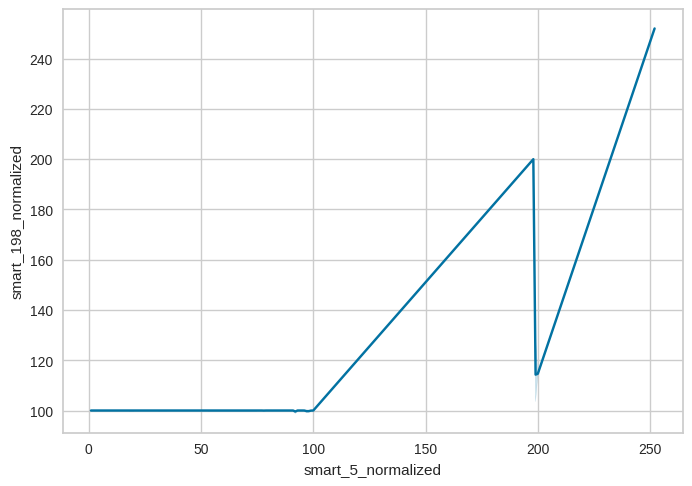

In [63]:
# There seems to be correlation between SMART 5 and SMART 198
# and also between SMART 197 and SMART 198, all normalized
# SMART 197 and 198 raw seems to have the highest correlation of 0.94
sns.lineplot(data = data, x = "smart_5_normalized", y = "smart_198_normalized")

<Axes: xlabel='smart_197_normalized', ylabel='smart_198_normalized'>

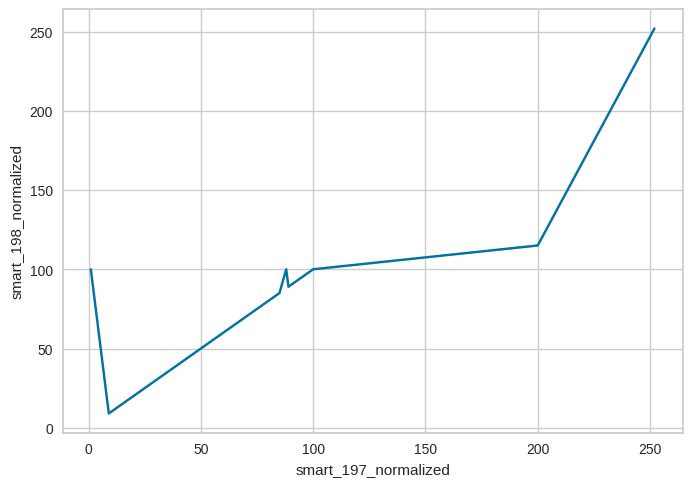

In [64]:
sns.lineplot(data = data, x = "smart_197_normalized", y = "smart_198_normalized")

<Axes: xlabel='smart_197_raw', ylabel='smart_198_raw'>

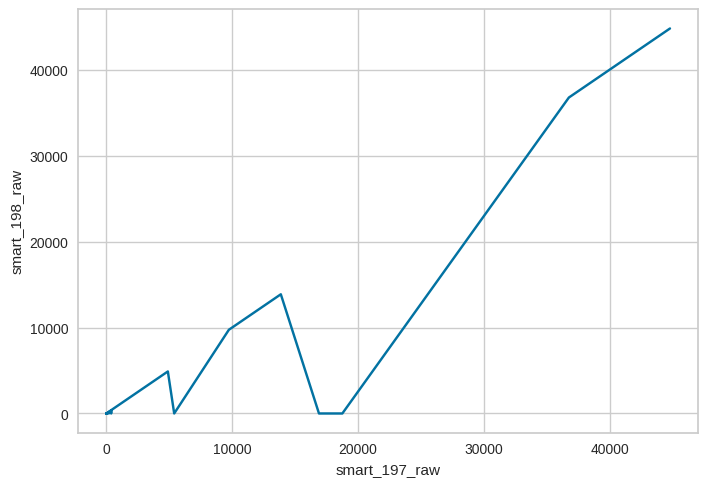

In [65]:
sns.lineplot(data = data, x = "smart_197_raw", y = "smart_198_raw")

In [66]:
# Setup for pycaret
# We cannot use days left till failure in our data as we won't have that data available
from pycaret.classification import *
data_1 = data.drop(["date_diff"], axis = 1)
s = setup(data_1, target = 'failure', experiment_name = 'classification_1')

,Description,Value
0,Session id,1878
1,Target,failure
2,Target type,Binary
3,Original data shape,"(232690, 8)"
4,Transformed data shape,"(232690, 8)"
5,Transformed train set shape,"(162883, 8)"
6,Transformed test set shape,"(69807, 8)"
7,Numeric features,7
8,Preprocess,True
9,Imputation type,simple


In [67]:
# Now, we compare different models
best = compare_models(sort = "Precision")

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9940,0.7299,0.0761,0.5829,0.1339,0.1327,0.2076,18.8680
rf,Random Forest Classifier,0.9939,0.7106,0.0751,0.5350,0.1311,0.1298,0.1978,9.0380
dt,Decision Tree Classifier,0.9939,0.6629,0.0731,0.5254,0.1278,0.1265,0.1934,0.1820
et,Extra Trees Classifier,0.9939,0.6877,0.0721,0.5235,0.1263,0.1250,0.1919,11.1200
xgboost,Extreme Gradient Boosting,0.9940,0.7508,0.0631,0.6137,0.1135,0.1125,0.1929,1.2020
knn,K Neighbors Classifier,0.9940,0.6061,0.0501,0.5999,0.0914,0.0905,0.1685,89.1130
qda,Quadratic Discriminant Analysis,0.9832,0.6760,0.0491,0.0270,0.0347,0.0270,0.0282,0.7870
gbc,Gradient Boosting Classifier,0.9940,0.7653,0.0381,0.6528,0.0709,0.0703,0.1506,7.4450
lda,Linear Discriminant Analysis,0.9931,0.7084,0.0120,0.0814,0.0207,0.0192,0.0286,0.3390
ada,Ada Boost Classifier,0.9939,0.7592,0.0110,0.5150,0.0214,0.0212,0.0708,3.9560


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

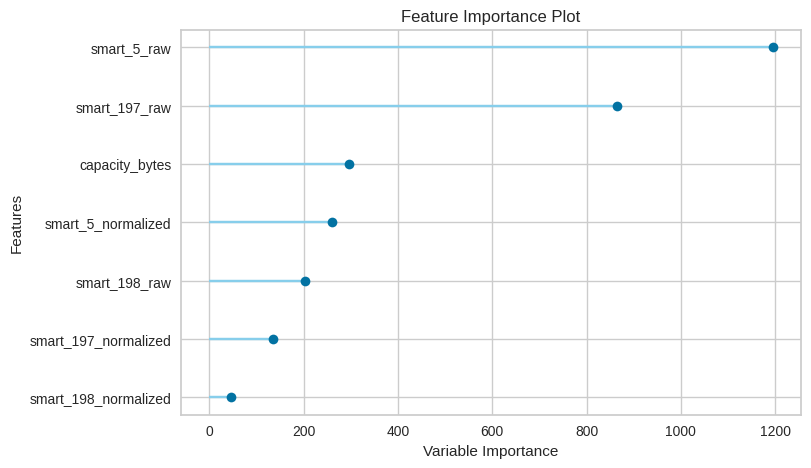

In [68]:
# It seems gradient boosting perform the best
# Let's check the feature importance
plot_model(best, plot = 'feature')

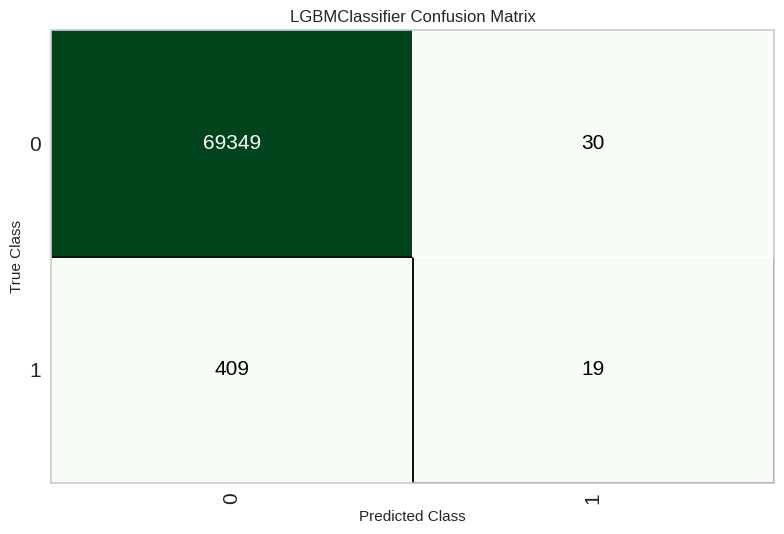

In [69]:
plot_model(best, plot = "confusion_matrix")

In [70]:
# Let's try predicting on the test set
predict_model(best)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9937,0.7313,0.0444,0.3878,0.0797,0.0785,0.1296


,capacity_bytes,smart_5_normalized,smart_5_raw,smart_197_normalized,smart_197_raw,smart_198_normalized,smart_198_raw,failure,prediction_label,prediction_score
198446,4000787030016,100.0,0.0,100.0,0.0,100.0,0.0,0,0,0.9975
194269,3000592982016,100.0,0.0,100.0,0.0,100.0,0.0,0,0,0.9961
192419,2000398934016,100.0,7.0,100.0,1.0,100.0,0.0,0,0,0.9966
145981,4000787030016,100.0,0.0,100.0,0.0,100.0,0.0,0,0,0.9975
13124,4000787030016,100.0,0.0,100.0,0.0,100.0,0.0,0,0,0.9975
...,...,...,...,...,...,...,...,...,...,...
135123,4000787030016,100.0,0.0,100.0,0.0,100.0,0.0,0,0,0.9975
135317,4000787030016,100.0,0.0,100.0,8.0,100.0,8.0,0,0,0.9882
40041,4000787030016,100.0,0.0,100.0,0.0,100.0,0.0,0,0,0.9975
95131,500107862016,252.0,0.0,252.0,0.0,252.0,0.0,0,0,0.9946


Our Failure classifier performs decently.<br>
But, it is not very useful to predict that a hard drive has failed on the day of failure, rather we would like to predict that a hard drive is close to failure, within lets say 10 days.

# Failure Classification 2

In [94]:
# First, we redifine our target class
final = 20
data_2 = data.copy()
days = data_2["date_diff"]
classes = []
for i in days:
  if i <= final:
    classes.append(1)
  else:
    classes.append(0)

data_2["failure"] = classes
data_2.head()

,capacity_bytes,failure,smart_5_normalized,smart_5_raw,smart_197_normalized,smart_197_raw,smart_198_normalized,smart_198_raw,date_diff
0,8001563222016,1,100.0,472.0,81.0,9736.0,81.0,9736.0,0
1,4000787030016,1,100.0,0.0,100.0,0.0,100.0,0.0,0
2,4000787030016,1,100.0,0.0,100.0,136.0,100.0,136.0,0
3,4000787030016,1,100.0,0.0,99.0,320.0,99.0,320.0,0
4,8001563222016,1,100.0,0.0,100.0,0.0,100.0,0.0,1


<Axes: xlabel='failure', ylabel='count'>

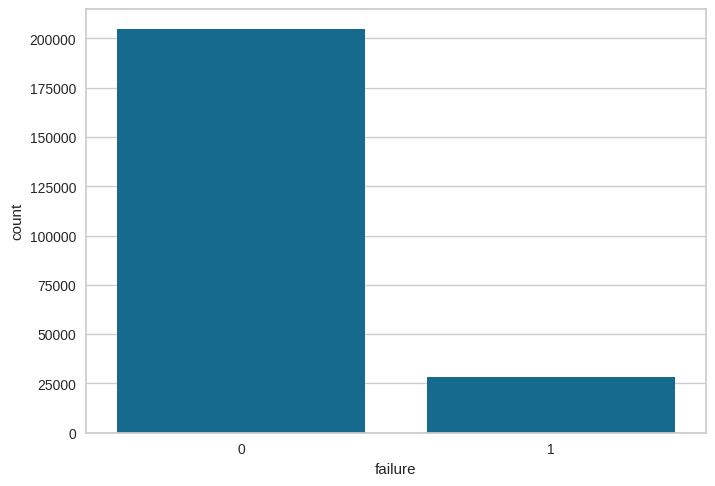

In [95]:
# Let's check the distribution again
sns.countplot(data = data_2, x = "failure")

In [96]:
# Redifine Setup for pycaret
# We cannot use days left till failure in our data as we won't have that data available
from pycaret.classification import *
data_2 = data_2.drop(["date_diff"], axis = 1)
s_2 = setup(data_2, target = 'failure', experiment_name = 'classification_2')

,Description,Value
0,Session id,7865
1,Target,failure
2,Target type,Binary
3,Original data shape,"(232690, 8)"
4,Transformed data shape,"(232690, 8)"
5,Transformed train set shape,"(162883, 8)"
6,Transformed test set shape,"(69807, 8)"
7,Numeric features,7
8,Preprocess,True
9,Imputation type,simple


In [97]:
# Now, we compare different models
best_1 = compare_models(sort = "Precision")

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.8869,0.6621,0.1077,0.7113,0.1870,0.1603,0.2472,11.3190
dt,Decision Tree Classifier,0.8869,0.6610,0.1073,0.7097,0.1864,0.1597,0.2464,0.3990
rf,Random Forest Classifier,0.8869,0.6621,0.1075,0.7089,0.1866,0.1599,0.2464,7.7400
ridge,Ridge Classifier,0.8793,0.5968,0.0006,0.7000,0.0011,0.0010,0.0181,0.2920
xgboost,Extreme Gradient Boosting,0.8857,0.6604,0.0964,0.6902,0.1691,0.1438,0.2288,1.8420
lightgbm,Light Gradient Boosting Machine,0.8857,0.6601,0.0978,0.6880,0.1712,0.1455,0.2299,16.0100
gbc,Gradient Boosting Classifier,0.8839,0.6457,0.0777,0.6649,0.1391,0.1168,0.1998,8.4010
knn,K Neighbors Classifier,0.8826,0.5866,0.1135,0.5981,0.1873,0.1544,0.2201,90.5120
ada,Ada Boost Classifier,0.8816,0.6421,0.0745,0.5750,0.1319,0.1071,0.1756,3.3800
lda,Linear Discriminant Analysis,0.8791,0.5969,0.0014,0.5208,0.0028,0.0020,0.0197,0.3570


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

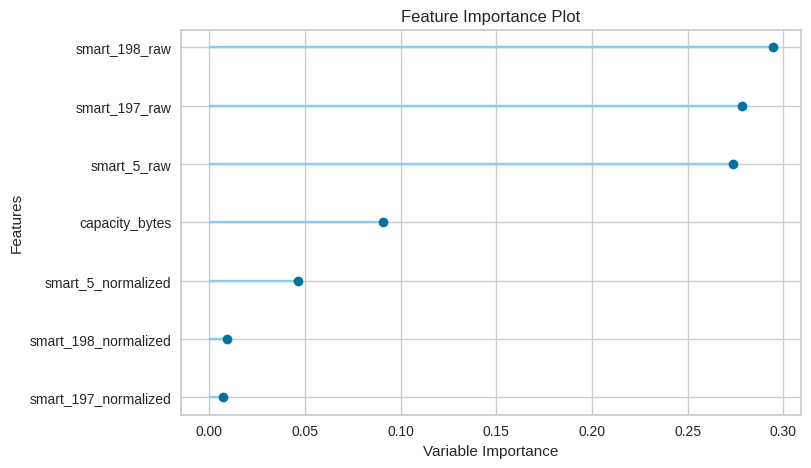

In [98]:
# Let's check the feature importance
plot_model(best_1, plot = 'feature')

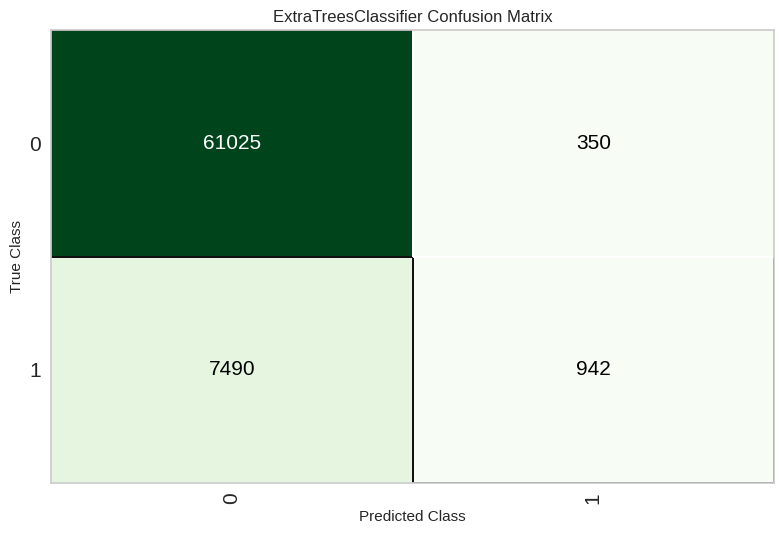

In [99]:
plot_model(best_1, plot = "confusion_matrix")

In [100]:
#Let's try predicting on the test set
predict_model(best_1)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.8877,0.6618,0.1117,0.7291,0.1937,0.1670,0.2563


,capacity_bytes,smart_5_normalized,smart_5_raw,smart_197_normalized,smart_197_raw,smart_198_normalized,smart_198_raw,failure,prediction_label,prediction_score
196654,4000787030016,100.0,16.0,100.0,0.0,100.0,0.0,0,0,0.7722
104688,160041885696,200.0,0.0,200.0,0.0,200.0,0.0,0,0,0.8869
39818,4000787030016,100.0,0.0,100.0,0.0,100.0,0.0,0,0,0.9149
189226,4000787030016,100.0,8.0,100.0,0.0,100.0,0.0,0,0,0.8326
9494,4000787030016,100.0,0.0,100.0,0.0,100.0,0.0,0,0,0.9149
...,...,...,...,...,...,...,...,...,...,...
113851,4000787030016,100.0,0.0,100.0,0.0,100.0,0.0,0,0,0.9149
59030,4000787030016,100.0,0.0,100.0,0.0,100.0,0.0,0,0,0.9149
118799,4000787030016,100.0,0.0,100.0,0.0,100.0,0.0,0,0,0.9149
45729,4000787030016,100.0,0.0,100.0,0.0,100.0,0.0,0,0,0.9149


Another way to interpret the problem is to predict number of days till failure

# Regression Analysis

In [80]:
# Redefining the data
data_3 = data.drop(["failure"], axis = 1)

In [82]:
from pycaret.regression import *
# Redefine Setup for pycaret
# We cannot use days left till failure in our data as we won't have that data available
s_2 = setup(data_3, target = 'date_diff', experiment_name = 'regression_1')

,Description,Value
0,Session id,2888
1,Target,date_diff
2,Target type,Regression
3,Original data shape,"(232690, 8)"
4,Transformed data shape,"(232690, 8)"
5,Transformed train set shape,"(162883, 8)"
6,Transformed test set shape,"(69807, 8)"
7,Numeric features,7
8,Preprocess,True
9,Imputation type,simple


In [84]:
# Now, we compare different models
best_2 = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,64.2007,6277.2287,79.2283,0.1246,1.0516,2.4179,16.4590
rf,Random Forest Regressor,64.2245,6279.0536,79.2398,0.1243,1.0523,2.4210,10.9470
dt,Decision Tree Regressor,64.2104,6280.3249,79.2479,0.1241,1.0520,2.4191,0.3030
xgboost,Extreme Gradient Boosting,64.4470,6294.9739,79.3401,0.1221,1.0559,2.4359,1.6990
lightgbm,Light Gradient Boosting Machine,64.6167,6304.3063,79.3990,0.1208,1.0620,2.4614,12.0380
gbr,Gradient Boosting Regressor,65.7283,6435.9859,80.2239,0.1024,1.0785,2.5333,6.9930
ada,AdaBoost Regressor,68.6374,6711.8147,81.9250,0.0640,1.1322,2.9097,2.2230
knn,K Neighbors Regressor,67.9327,7008.3177,83.6689,0.0226,1.0929,2.6340,45.1810
br,Bayesian Ridge,69.9067,7093.7487,84.2237,0.0107,1.1487,2.9821,0.2250
en,Elastic Net,69.9063,7093.7354,84.2236,0.0107,1.1486,2.9821,4.0170


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

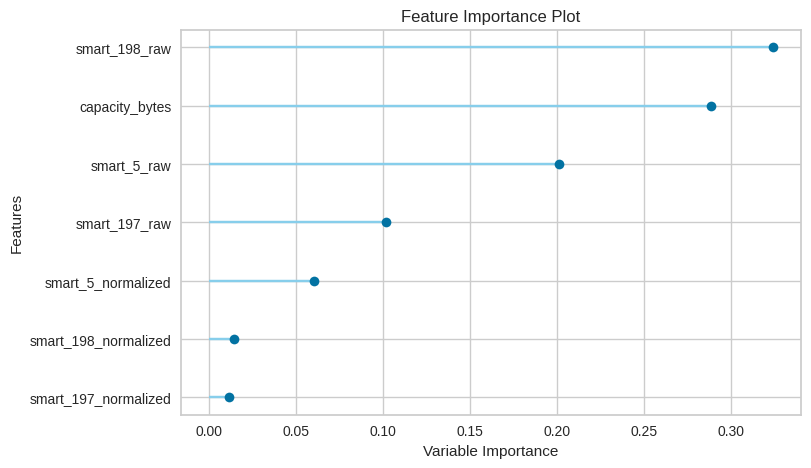

In [85]:
# It seems extra trees perform the best
# Let's check the feature importance
plot_model(best_2, plot = 'feature')

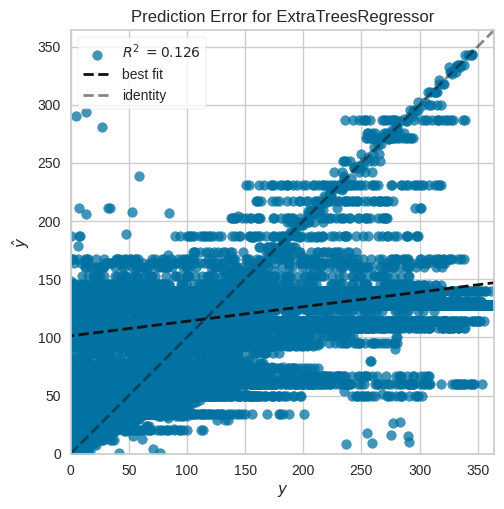

In [88]:
plot_model(best_2, plot = "error")

In [89]:
#Let's try predicting on the test set
predict_model(best_2)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,64.4758,6319.9806,79.4983,0.1260,1.0598,2.5214


,capacity_bytes,smart_5_normalized,smart_5_raw,smart_197_normalized,smart_197_raw,smart_198_normalized,smart_198_raw,date_diff,prediction_label
140721,4000787030016,100.0,0.0,100.0,0.0,100.0,0.0,178,127.459119
217484,4000787030016,100.0,0.0,100.0,0.0,100.0,0.0,345,127.459119
175527,4000787030016,100.0,0.0,100.0,0.0,100.0,0.0,263,127.459119
78635,4000787030016,100.0,0.0,100.0,0.0,100.0,0.0,47,127.459119
103812,4000787030016,100.0,0.0,100.0,0.0,100.0,0.0,142,127.459119
...,...,...,...,...,...,...,...,...,...
92446,4000787030016,100.0,0.0,100.0,0.0,100.0,0.0,90,127.459119
39104,4000787030016,100.0,0.0,100.0,8.0,100.0,8.0,19,59.806668
135986,4000787030016,100.0,0.0,100.0,0.0,100.0,0.0,37,127.459119
77121,4000787030016,100.0,0.0,100.0,0.0,100.0,0.0,207,127.459119
